# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [18]:
import pandas as pd
import numpy as np

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [4]:
from sklearn.model_selection import train_test_split

X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd']
X = X.drop('salary', axis=1)

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=0)

Признак `salary` следует удалить, поскольку он косвенно, а иногда и напрямую указывает на таргет.

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_features = ['experience_level', 'employment_type', 'job_title',
                        'salary_currency', 'employee_residence', 'company_location', 'company_size']
pp = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough'
)
lr = Pipeline(steps=[('preprocessor', pp), ('regression', LinearRegression())])
lr.fit(X_train, y_train)
prediction = lr.predict(X_val)

mape = mean_absolute_percentage_error(y_val, prediction)
rmse = np.sqrt(mean_squared_error(y_val, prediction))
print(f'MAPE: {mape:.3%}')
print(f'RMSE: {rmse:.3f}')

MAPE: 37.485%
RMSE: 53513.676


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [15]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

params = {
    'xgb_regressor__max_depth': [1, 3, 6, 9],
    'xgb_regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb_regressor__n_estimators': [50, 100, 150, 200, 250],
    'xgb_regressor__gamma': [0, 0.1, 0.2, 0.4],
}
xgb = Pipeline(steps=[
    ('preprocessor', pp),
    ('xgb_regressor', XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    ))
])
gs = GridSearchCV(
    estimator=xgb,
    param_grid=params,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
gs.fit(X_train, y_train)
print(f'Best params: {gs.best_params_}')

Fitting 3 folds for each of 320 candidates, totalling 960 fits
Best params: {'xgb_regressor__gamma': 0, 'xgb_regressor__learning_rate': 0.1, 'xgb_regressor__max_depth': 3, 'xgb_regressor__n_estimators': 250}


In [20]:
import time

best = Pipeline(steps=[
    ('preprocessor', pp),
    ('xgb_regressor', XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    ))
])
best.set_params(**gs.best_params_)
start_train = time.time()
best.fit(X_train, y_train)
end_train = time.time()
training_time = end_train - start_train
start_pred = time.time()
y_pred = best.predict(X_test)
end_pred = time.time()
prediction_time = end_pred - start_pred
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAPE: {mape:.3%}")
print(f"RMSE: {rmse:.3f}")
print(f"Training Time: {training_time:.3f} sec")
print(f"Prediction Time: {prediction_time:.3f} sec")

MAPE: 33.490%
RMSE: 49871.297
Training Time: 0.183 sec
Prediction Time: 0.024 sec


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [24]:
from catboost import CatBoostRegressor

params = {
    'catboost_regressor__depth' : [1, 3, 6, 9],
    'catboost_regressor__learning_rate' : [0.01, 0.05, 0.1, 0.2],
    'catboost_regressor__iterations' : [50, 100, 150, 200]
}
cb = Pipeline(steps=[
    ('preprocessor', pp),
    ('catboost_regressor', CatBoostRegressor(
        loss_function='RMSE',
        verbose=False
    ))
])
gs = GridSearchCV(
    estimator=cb,
    param_grid=params,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
gs.fit(X_train, y_train)
print(f'Best params: {gs.best_params_}')

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best params: {'catboost_regressor__depth': 6, 'catboost_regressor__iterations': 100, 'catboost_regressor__learning_rate': 0.2}


In [26]:
best = Pipeline(steps=[
    ('preprocessor', pp),
    ('catboost_regressor', CatBoostRegressor(
        loss_function='RMSE',
        verbose=False,
        random_state=42
    ))
])
best.set_params(**gs.best_params_)
start_train = time.time()
best.fit(X_train, y_train)
end_train = time.time()
training_time = end_train - start_train
start_pred = time.time()
y_pred = best.predict(X_test)
end_pred = time.time()
prediction_time = end_pred - start_pred
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAPE: {mape:.3%}")
print(f"RMSE: {rmse:.3f}")
print(f"Training Time: {training_time:.3f} sec")
print(f"Prediction Time: {prediction_time:.3f} sec")

MAPE: 33.647%
RMSE: 49170.134
Training Time: 0.571 sec
Prediction Time: 0.048 sec


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [32]:
from catboost import Pool, cv

indices = [X_train.columns.get_loc(f) for f in categorical_features if f in X_train]
train_pool = Pool(data=X_train, label=y_train, cat_features=indices)
val_pool = Pool(data=X_val, label=y_val, cat_features=indices)
best_params = {}
score = np.inf
for depth in params['catboost_regressor__depth']:
  for learning_rate in params['catboost_regressor__learning_rate']:
    for iterations in params['catboost_regressor__iterations']:
      par = {
        'depth': depth,
        'learning_rate': learning_rate,
        'iterations': iterations,
        'loss_function': 'RMSE',
        'verbose': False
      }
      result = cv(
        pool=train_pool,
        params=par,
        fold_count=3,
        type='Classical',
        verbose=False
      )
      current_score = np.mean(result['test-RMSE-mean'])
      if current_score < score:
        score = current_score
        best_params = par.copy()
print(f"Best params: {best_params}")
print(f"Best score: {score}")

Training on fold [0/3]

bestTest = 100858.852
bestIteration = 49

Training on fold [1/3]

bestTest = 104105.1183
bestIteration = 49

Training on fold [2/3]

bestTest = 101730.3576
bestIteration = 49

Training on fold [0/3]

bestTest = 74869.70003
bestIteration = 99

Training on fold [1/3]

bestTest = 78803.69062
bestIteration = 99

Training on fold [2/3]

bestTest = 76578.30411
bestIteration = 99

Training on fold [0/3]

bestTest = 61471.66452
bestIteration = 149

Training on fold [1/3]

bestTest = 64572.328
bestIteration = 149

Training on fold [2/3]

bestTest = 63035.35083
bestIteration = 149

Training on fold [0/3]

bestTest = 55640.00283
bestIteration = 199

Training on fold [1/3]

bestTest = 57919.94476
bestIteration = 199

Training on fold [2/3]

bestTest = 57208.09353
bestIteration = 199

Training on fold [0/3]

bestTest = 52982.73548
bestIteration = 49

Training on fold [1/3]

bestTest = 54782.18122
bestIteration = 49

Training on fold [2/3]

bestTest = 54764.3747
bestIteration

In [34]:
best = Pipeline(steps=[
    ('preprocessor', pp),
    ('catboost_regressor', CatBoostRegressor(
        loss_function='RMSE',
        verbose=False,
        random_state=42
    ))
])
params = {
   'catboost_regressor__depth' : best_params['depth'],
   'catboost_regressor__learning_rate' : best_params['learning_rate'],
   'catboost_regressor__iterations' : best_params['iterations']
}
best.set_params(**params)
start_train = time.time()
best.fit(X_train, y_train)
end_train = time.time()
training_time = end_train - start_train
start_pred = time.time()
y_pred = best.predict(X_test)
end_pred = time.time()
prediction_time = end_pred - start_pred
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAPE: {mape:.3%}")
print(f"RMSE: {rmse:.3f}")
print(f"Training Time: {training_time:.3f} sec")
print(f"Prediction Time: {prediction_time:.3f} sec")

MAPE: 34.064%
RMSE: 49409.204
Training Time: 0.664 sec
Prediction Time: 0.018 sec


**Ответ:** Качество модели не улучшилось, время обучение значительно увеличилось, а вот время предсказания уменьшилось.

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [38]:
from lightgbm import LGBMRegressor

params = {
    'lgbmregressor__max_depth' : [10, 15, 20, 30],
    'lgbmregressor__learning_rate' : [0.01, 0.05, 0.1, 0.2],
    'lgbmregressor__n_estimators' : [50, 100, 150, 200, 250]
}
lgbmr = Pipeline(steps=[
    ('preprocessor', pp),
    ('lgbmregressor', LGBMRegressor(
        objective='regression',
        verbose=0
    ))
])
gs = GridSearchCV(
    estimator=lgbmr,
    param_grid=params,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
gs.fit(X_train, y_train)
print(f'Best params: {gs.best_params_}')

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [41]:
best = Pipeline(steps=[
    ('preprocessor', pp),
    ('lgbmregressor', LGBMRegressor(
        verbose=0,
        random_state=42
    ))
])
best.set_params(**gs.best_params_)
start_train = time.time()
best.fit(X_train, y_train)
end_train = time.time()
training_time = end_train - start_train
start_pred = time.time()
y_pred = best.predict(X_test)
end_pred = time.time()
prediction_time = end_pred - start_pred
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAPE: {mape:.3%}")
print(f"RMSE: {rmse:.3f}")
print(f"Training Time: {training_time:.3f} sec")
print(f"Prediction Time: {prediction_time:.3f} sec")

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
MAPE: 33.654%
RMSE: 49899

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:**


| Модель | Гиперпараметры | MAPE | RMSE| Время обучения| Время предсказания|
| ----------- | ----------- | ---------| ------|------|-----
|XGBoost| gamma: 0, learning_rate: 0.1, max_depth: 3, n_estimators: 250|33.490%|49871.297|0.183 sec|0.024 sec|
| CatBoost |depth: 3, learning_rate: 0.2, iterations: 200 |34.064%|49409.204|0.664 sec|0.018 sec|
| LightGBM|learning_rate: 0.1, max_depth: 10, n_estimators: 50|33.654%|49899.046|0.073 sec|0.011 sec|

- CatBoost и XGBoost демонстрируют схожее качество, но CatBoost немного лучше минимизирует крупные ошибки (RMSE).

- LightGBM значительно лучше других моделей и по времени обучения, и по времени предсказания.


Таким образом, CatBoost показывает лучшее качество, а LightGBM - лучшее время, XGBoost же более универсален и показывает достойный результат как по скорости, так и по качеству.

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [1]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [7]:
ratings = ratings.transpose()
ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [11]:
ratings = ratings.drop('user', axis=0)
ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [39]:
ratings = ratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
franz ferdinand,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014344,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [21]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=5, random_state=42)
km.fit(ratings)
labels = km.labels_

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [22]:
u, c = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(u, c))
print({int(k): int(v) for k, v in cluster_sizes.items()})

{0: 115, 1: 1, 2: 1, 3: 882, 4: 1}


**Ответ:** Кластеризация получилась не очень полезной, один кластер содержит 882 исполнителя, а 1, 2 и 4 получили всего по одному. Это могло произойти из-за неправильного выбора количества кластеров или метрики.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [31]:
artists = ratings.index[np.isin(labels, [1, 2, 4])]
print(artists)

Index(['the beatles', 'niИ', '日dir en grey'], dtype='object')


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [44]:
print(ratings.index.tolist())
beatles_ind = ratings.index.get_loc('the beatles')
users_listening = (ratings > 0).sum(axis=1)
user_share = users_listening / ratings.shape[1]
artist_share = ratings.mean(axis=1)
print(f'Share of users who listen to The Beatles: {user_share[beatles_ind]:.4f}')
print(f'Mean share of plays of The Beatles: {artist_share[beatles_ind]:.4f}')
print(user_share.head(20))
print(artist_share.head(20))

['the beatles', 'radiohead', 'deathcab for cutie', 'coldplay', 'modest mouse', 'sufjan stevens', 'dylan. bob', 'red hot clili peppers', 'pink fluid', 'kanye west', 'niИ', 'the shins', 'led zeppelin.', 'elliotte smith', 'beck', 'divid bowie', 'the killers', 'daft punk', 'the arcade fire', 'muse', 'the smashing pumpkins', 'white stripes', 'the decemberists', 'the rolling stones', 'bright eyes', 'the pixies', 'belle and sebastian', 'sigur rós', 'ironand wine', 'the cure', 'greenday', 'blink-182', 'johnson jack', '\u200clinkin park', 'johnny clash', 'gorillaz', 'incubus', 'queen', 'animal collective', 'u2', 'the smiths', 'of montreal', 'fall out boy', 'brand new', '￼beastie boys', 'spoon', 'nirvana', 'the postal service', 'bloc party', 'foo fighters', 'the clash', 'björk guğmunsdóttir', 'metallica', 'cake', 'sublime', 'interpol', 'regina spektor', 'tom waits', 'john mayer', 'andrew bird', 'neutral milk hotel', 'broken social scene', 'tool', 'the flaming lips', 'the strokes', 'r.e.m.', 'gir

<ipython-input-44-3917239387>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Share of users who listen to The Beatles: {user_share[beatles_ind]:.4f}')
<ipython-input-44-3917239387>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Mean share of plays of The Beatles: {artist_share[beatles_ind]:.4f}')


**Ответ:** The Beatles слушает максимальное количество пользователей, и они имеют максимальную среднюю долю прослушиваний.

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [46]:
from sklearn.preprocessing import normalize

normalized = normalize(ratings)

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [47]:
km.fit(normalized)
u, c = np.unique(km.labels_, return_counts=True)
cluster_sizes = dict(zip(u, c))
print({int(k): int(v) for k, v in cluster_sizes.items()})

{0: 79, 1: 162, 2: 133, 3: 140, 4: 486}


**Ответ** Да, кластеризация стала лучше и теперь может быть полезной. Теперь кластеры имеют более сбалансированное распределение.

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [52]:
from scipy.spatial.distance import cosine

centroids = km.cluster_centers_
top = {}
for i, c in enumerate(centroids):
    distances = [cosine(c, normalized[j]) for j in range(len(normalized))]
    closest = sorted(range(len(distances)), key=lambda x: distances[x])[:10]
    top[i] = ratings.index[closest]
for id, artists in top.items():
    print(f"{id}: {', '.join(artists)}")

0: nas, jay-z, kanye west, lupe the gorilla, a tribe called quest, the roots featuring d'angelo, gangstarr, little brother, lil' wayne, murs and 9th wonder
1: fall out boy, the all-americian rejects, paramore, kelly clarkson, john mayer, the fray, maroon5, dashboard confesssional, somethings corporate, coldplay
2: brand new, blink-182, alkaline trio, against me!, underoath, descendents, new found glory, less than jake, thrice, chiodos
3: the beatles, the rolling stones, dylan. bob, who, led zeppelin., miles davis., simon and garfunkel, young, neil, pink fluid, velvet underground
4: radiohead, the arcade fire, the shins, sufjan stevens, belle and sebastian, broken social scene, the pixies, animal collective, modest mouse, spoon


**Ответ:** Теперь кластеры разделяют исполнителям по жанрам, в одном кластере находятся исполнители одного жанра (например, в кластере 3 находятся исполнители классического рока).

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

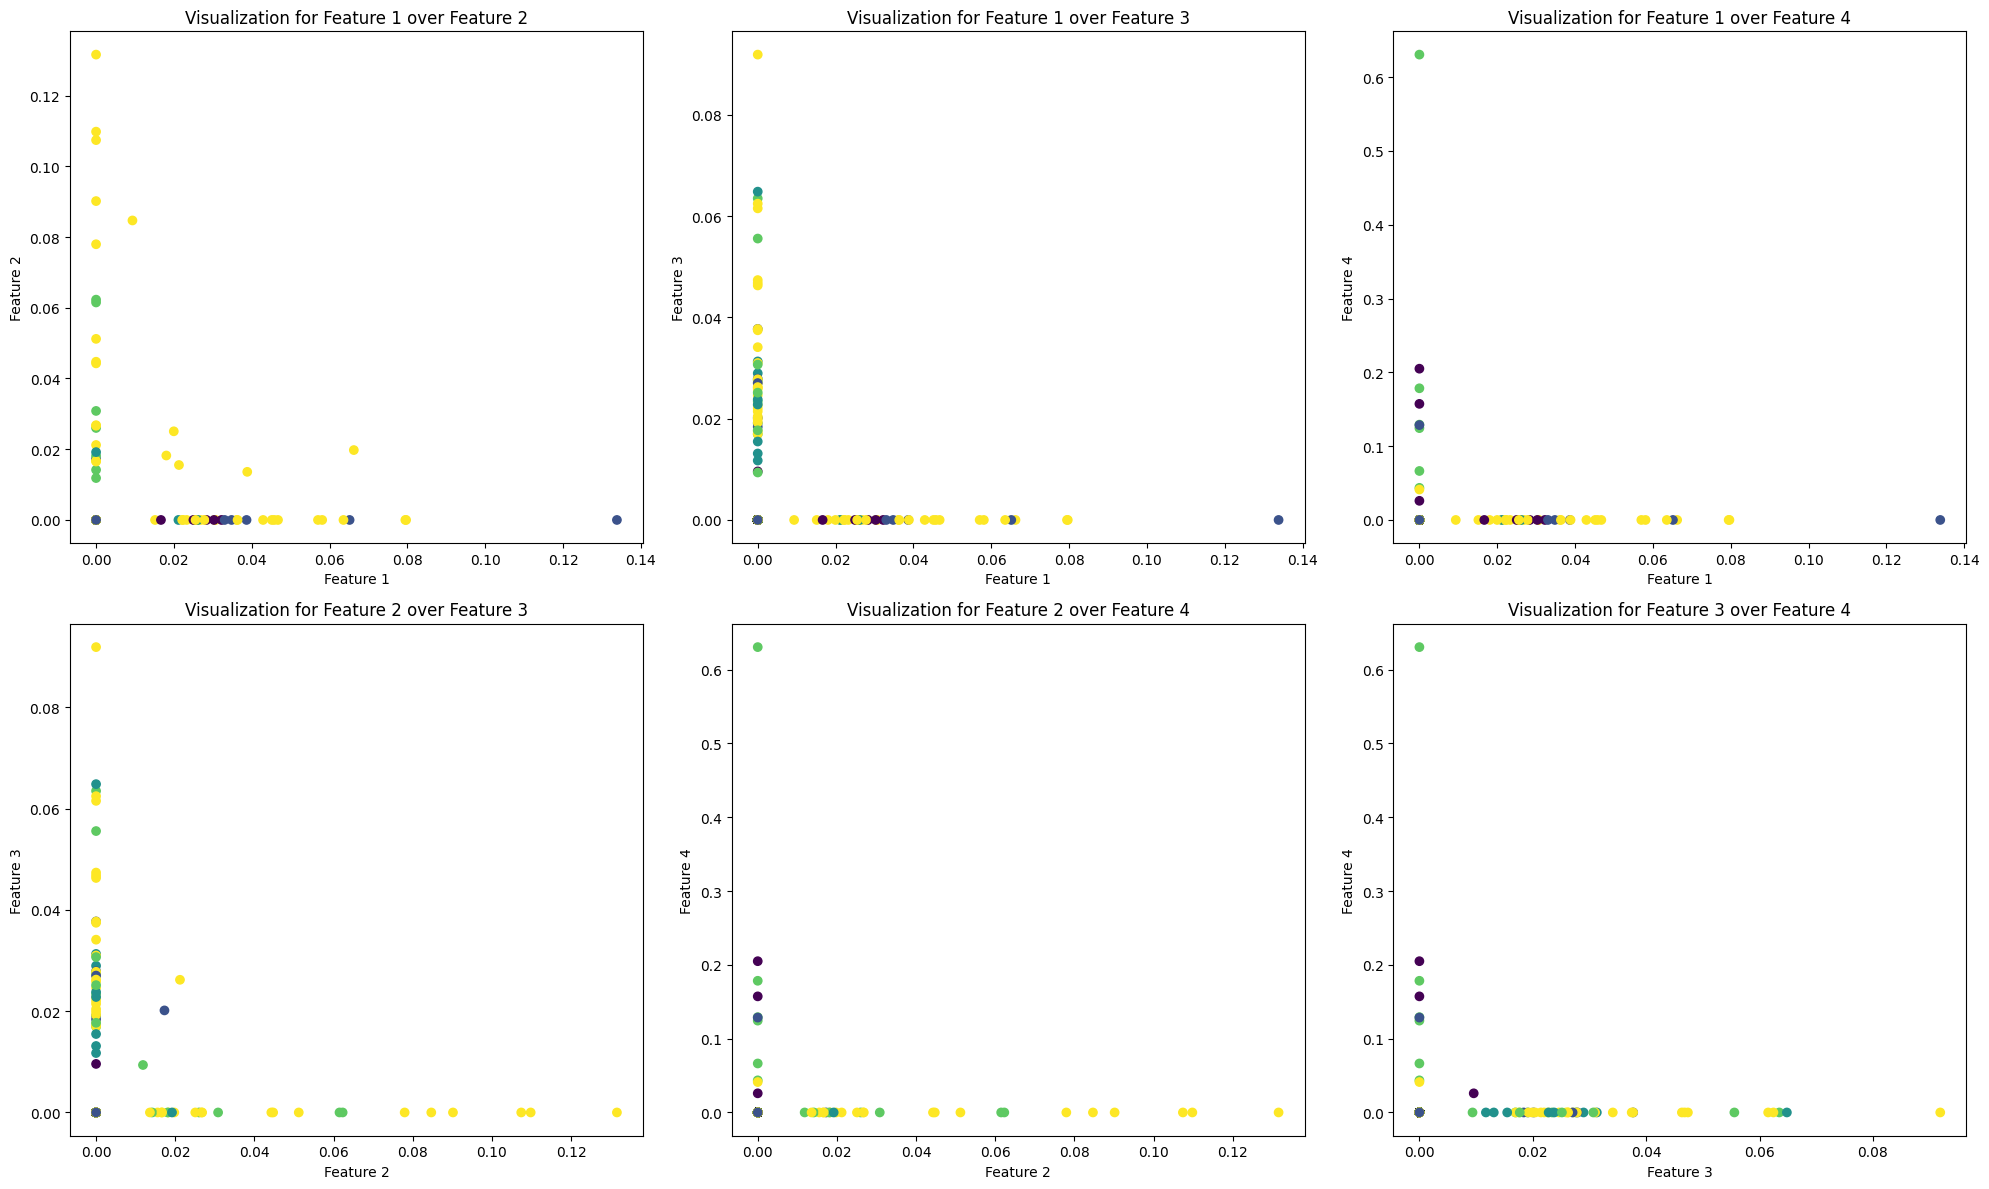

In [78]:
import matplotlib.pyplot as plt
features = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
plt.figure(figsize=(20, 12))
for i, (f1, f2) in enumerate(features, 1):
    plt.subplot(2, 3, i)
    plt.scatter(normalized[:, f1], normalized[:, f2], c=km.labels_)
    plt.title(f"Visualization for Feature {f1 + 1} over Feature {f2 + 1}")
    plt.xlabel(f"Feature {f1 + 1}")
    plt.ylabel(f"Feature {f2 + 1}")
plt.tight_layout()
plt.show()

**Ответ:** Графики получились не очень информативными, кластеры на них не видны. Это произошло из-за того, что визуализация в 2D не отражает полной картины, исполнители имеют более 2 признаков.

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

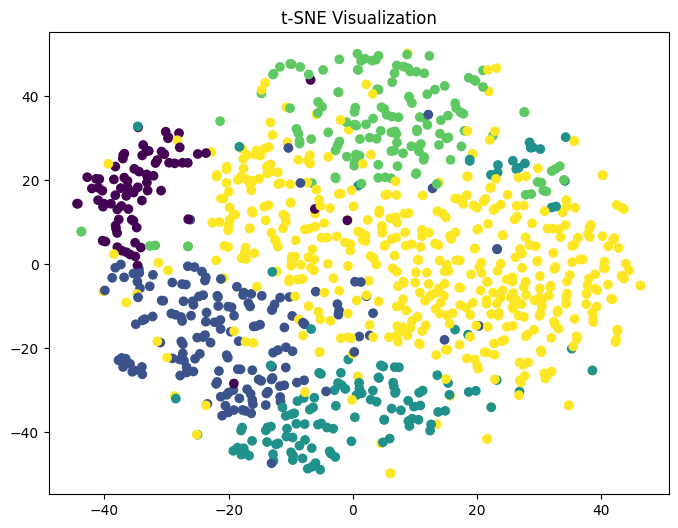

In [79]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
ratings_tsne = tsne.fit_transform(normalized)
plt.figure(figsize=(8, 6))
plt.scatter(ratings_tsne[:, 0], ratings_tsne[:, 1], c=km.labels_)
plt.title("t-SNE Visualization")
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [95]:
from sklearn.metrics import silhouette_score

best_score = -1
best_k = 2
for k in range(2, 101):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(normalized)
    score = silhouette_score(normalized, km.labels_)
    if score > best_score:
        best_score = score
        best_k = k
print(f"Best number of clusters: {best_k}")
print(f"Best silhouette score: {best_score}")

Best number of clusters: 98
Best silhouette score: 0.013327108441541903


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [82]:
best_km = KMeans(n_clusters=best_k, random_state=42)
best_km.fit(normalized)
centroids = best_km.cluster_centers_
top = {}
for i, c in enumerate(centroids):
    distances = [cosine(c, normalized[j]) for j in range(len(normalized))]
    closest = sorted(range(len(distances)), key=lambda x: distances[x])[:10]
    top[i] = ratings.index[closest]
for id, artists in top.items():
    print(f"{id}: {', '.join(artists)}")

0: dr. dre, the faint, violent femmes, margot and the nuclear so and sos, owen, the bloodhound gang, cursive, van hallen, bright eyes, ironand wine
1: john mayer, matt nathanson, gavin degraw, jason mraz, ray lamontagne, joshua radin, sara bareilles, augustana, maroon5, o.a.r.
2: white stripes, beck, the raconteurs, spoon, the pixies, the strokes, the flaming lips, cake, black rebel motorcycle club, gorillaz
3: fugazi, jawbreaker, sleater-kinney, les savy fav, capn jazz, bad brains, blonde redhead, propagandhi, the melvins, gogol bordello
4: ryan adams, band of horses, ryan adams and the cardinals, rogue wave, my morning jacket, matt pond pa, cloud cult, the american analog set, nada surf, tv on the radio
5: dj shadow, rjd2, amon tobin, jedi mind tricks, el-p, aphex twin, sublime, moby*, gnarls barkley, soul coughing
6: system of a down, koЯn, mudvayne, limpt bizkit, disturbed, slipknot, papa roach, godsmack, marilyn manson, fort minor
7: somethings corporate, the rocket summer, jack’s

**Ответ:** Да, смысл кластеров остался прежним. Интересными мне показались кластеры 73 (классическая музыка) и кластер 92 (саундтреки).

Сделайте t-SNE визуализацию полученной кластеризации.

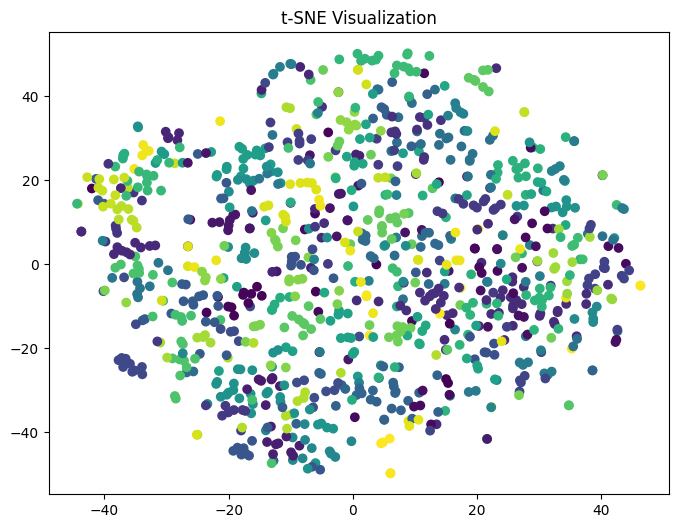

In [83]:
tsne = TSNE(n_components=2, random_state=42)
ratings_tsne = tsne.fit_transform(normalized)
plt.figure(figsize=(8, 6))
plt.scatter(ratings_tsne[:, 0], ratings_tsne[:, 1], c=best_km.labels_)
plt.title("t-SNE Visualization")
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

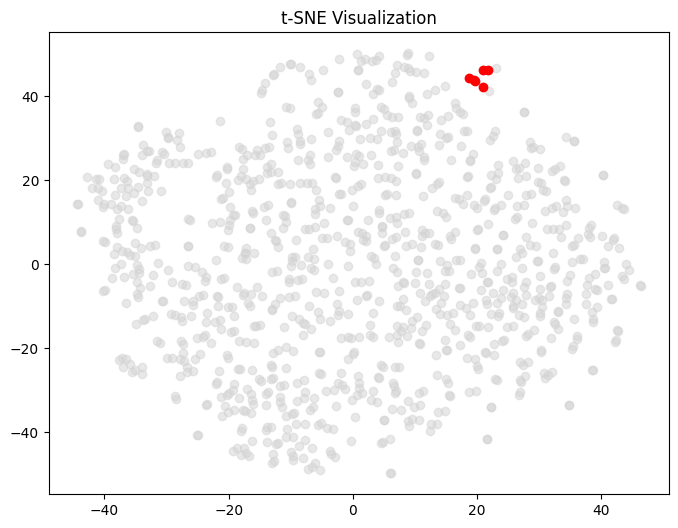

In [94]:
tsne = TSNE(n_components=2, random_state=42)
ratings_tsne = tsne.fit_transform(normalized)
plt.figure(figsize=(8, 6))
mask = (best_km.labels_ == 73)
plt.scatter(ratings_tsne[:, 0], ratings_tsne[:, 1], c='lightgray', alpha=0.5)
plt.scatter(ratings_tsne[mask, 0], ratings_tsne[mask, 1], c='red')
plt.title("t-SNE Visualization")
plt.show()

**Ответ:** Да, кластер хорошо отображается в визуализации.